# Classification of emotions

## Importing the libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

## Loading the images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# 감정 분류를 다룰 때 가장 자주 사용되는 데이터셋 중 하나
path = '/content/drive/MyDrive/Computer Vision/Datasets/fer_images.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

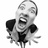

In [14]:
tf.keras.preprocessing.image.load_img('/content/fer2013/train/Angry/1003.jpg')

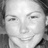

In [15]:
image = tf.keras.preprocessing.image.load_img('/content/fer2013/train/Happy/1.jpg')
image

### Train and test set

In [16]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('/content/fer2013/train',
                                                       target_size=(48,48),
                                                       batch_size=16,
                                                       class_mode='categorical',
                                                       shuffle=True)

Found 28709 images belonging to 7 classes.


In [17]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [18]:
np.unique(train_dataset.classes, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

In [19]:
train_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [20]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

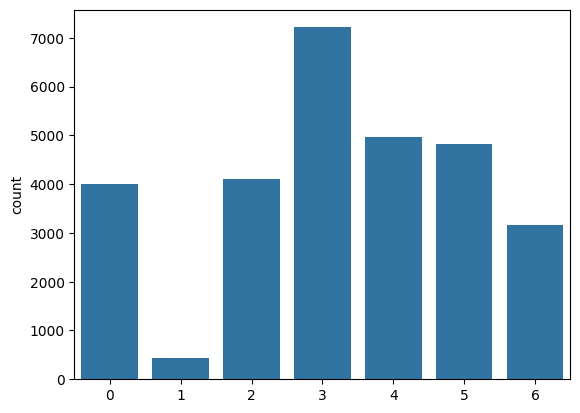

In [21]:
sns.countplot(x=train_dataset.classes);

In [22]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/fer2013/validation',
                                                       target_size=(48,48),
                                                       batch_size=1,
                                                       class_mode='categorical',
                                                       shuffle=False)

Found 3589 images belonging to 7 classes.


## Building and training the convolutional neural network

In [23]:
num_detectors = 32  # 필터 개수
num_classes = 7 # label 개수
width, height = 48, 48  # 이미지 크기
epochs = 100

network = Sequential()

network.add(Conv2D(num_detectors, (3,3), activation='relu', padding='same', input_shape=(width, height, 3)))
network.add(BatchNormalization())
network.add(Conv2D(num_detectors, (3,3), activation='relu', padding='same')) # 꼭 합성곱층 이후에 바로 풀링층이 오지 않아도 됨.
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding='same')) # 꼭 합성곱층 이후에 바로 풀링층이 오지 않아도 됨.
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding='same')) # 꼭 합성곱층 이후에 바로 풀링층이 오지 않아도 됨.
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding='same')) # 꼭 합성곱층 이후에 바로 풀링층이 오지 않아도 됨.
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

# padding='valid'  -> 특성맵 생성 과정 시 정보를 잃는 부분이 있을 수 있음
# padding='same'   -> 0이 있는 패딩을 적용
# 여기서는 흑백이미지임에도 3개의 채널이 있음.
# 이 이미지들은 각 채널의 값이 모두 동일함.
# BatchNormalization()  ->  정규화의 일종(배치 정규화)

network.add(Flatten())  # 행렬을 벡터로 변환

network.add(Dense(2*num_detectors, activation='relu'))   # 여기서는 은닉층 뉴런 개수 계산 공식을 사용 안함.
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(2*num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes, activation='softmax'))
print(network.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,328,743 (5.07 MB)

 Trainable params: 1,326,567 (5.06 MB)

 Non-trainable params: 2,176 (8.50 KB)

None


In [24]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
network.fit(train_dataset, epochs=100)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1795/1795 ━━━━━━━━━━━━━━━━━━━━ 73s 29ms/step - accuracy: 0.2193 - loss: 2.0224
Epoch 2/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.3714 - loss: 1.6030
Epoch 3/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 81s 24ms/step - accuracy: 0.4664 - loss: 1.3970
Epoch 4/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 81s 24ms/step - accuracy: 0.4987 - loss: 1.3189
Epoch 5/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.5289 - loss: 1.2601
Epoch 6/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.5480 - loss: 1.2162
Epoch 7/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 81s 24ms/step - accuracy: 0.5628 - loss: 1.1733
Epoch 8/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.5729 - loss: 1.1434
Epoch 9/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.5837 - loss: 1.1233
Epoch 10/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - accuracy: 0.5915 - loss: 1.1071
Epoch 11/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.5969 - loss: 1.0893
Epoch 12/

## Saving and loading the model

In [ ]:
model_json = network.to_json()
with open('network_emotions.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import save_model
network_saved = save_model(network, '/content/weights_emotions.hdf5')

In [ ]:
with open('/content/drive/MyDrive/Computer Vision/Weights/network_emotions.json', 'r') as json_file:
    json_saved_model = json_file.read()
json_saved_model  # 모델 구조

In [ ]:
# 가중치 로드
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('/content/drive/MyDrive/Computer Vision/Weights/weights_emotions.hdf5')
network_loaded.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
network_loaded.summary()

## Evaluating the neural network

In [ ]:
network_loaded.evaluate(test_dataset)
# 이 데이터셋은 원래 높은 정확도를 얻기 어려운 데이터임. 이 정도면 나쁘지 않은 정확도...
# 최신 기술을 사용하더라도 정확도가 약 75~80%에 그침.
# 전이학습으로도 미리 해봤더니 결과가 좋지 않았다고 함.

In [ ]:
predictions = network_loaded.predict(test_dataset)
predictions # 각 이미지마다 각 클래스에 대한 확률값이 나옴.

In [ ]:
predictions = np.argmax(predictions, axis=1)
predictions

In [ ]:
test_dataset.classes

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

In [ ]:
test_dataset.class_indices

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
cm

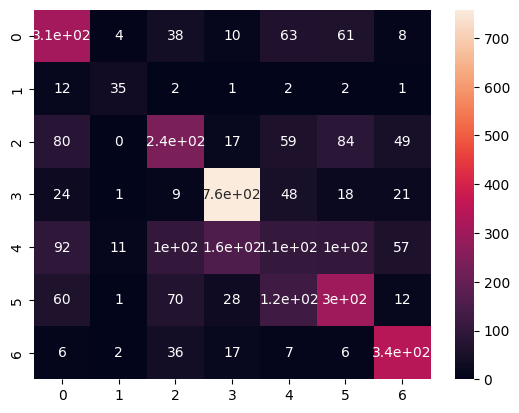

In [38]:
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

## Classifying one single image

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Computer Vision/Images/gabriel.png')
cv2_imshow(image)

In [ ]:
image.shape

In [ ]:
face_detector = cv2.CascadeClassifier('/content/drive/MyDrive/Computer Vision/Cascades/haarcascade_frontalface_default.xml')

In [ ]:
original_image = image.copy()
faces = face_detector.detectMultiScale(original_image)  # 얼굴 감지

In [ ]:
faces

In [ ]:
roi = image[40:40 + 128, 162:162 + 128]
cv2_imshow(roi) # 관심영역 추출

In [46]:
roi.shape

(128, 128, 3)

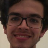

In [47]:
roi = cv2.resize(roi, (48,48))
cv2_imshow(roi)

In [48]:
roi.shape

(48, 48, 3)

In [49]:
roi,

(array([[[ 28,  32,  37],
         [ 22,  28,  34],
         [ 33,  37,  42],
         ...,
         [ 12,  16,  17],
         [ 16,  21,  25],
         [ 16,  25,  30]],
 
        [[ 27,  31,  36],
         [ 31,  36,  41],
         [ 32,  36,  41],
         ...,
         [ 11,  16,  19],
         [ 13,  19,  24],
         [ 17,  25,  28]],
 
        [[ 27,  31,  36],
         [ 30,  34,  39],
         [ 26,  30,  35],
         ...,
         [ 12,  17,  20],
         [ 14,  20,  25],
         [ 20,  25,  27]],
 
        ...,
 
        [[162, 185, 197],
         [166, 188, 200],
         [166, 188, 200],
         ...,
         [162, 181, 188],
         [162, 182, 188],
         [161, 180, 187]],
 
        [[160, 184, 196],
         [165, 187, 199],
         [166, 188, 200],
         ...,
         [161, 180, 187],
         [162, 181, 187],
         [161, 180, 187]],
 
        [[160, 184, 196],
         [163, 187, 199],
         [165, 187, 199],
         ...,
         [160, 179, 186],
  

In [50]:
roi = roi / 255  # 정규화
roi

array([[[0.10980392, 0.1254902 , 0.14509804],
        [0.08627451, 0.10980392, 0.13333333],
        [0.12941176, 0.14509804, 0.16470588],
        ...,
        [0.04705882, 0.0627451 , 0.06666667],
        [0.0627451 , 0.08235294, 0.09803922],
        [0.0627451 , 0.09803922, 0.11764706]],

       [[0.10588235, 0.12156863, 0.14117647],
        [0.12156863, 0.14117647, 0.16078431],
        [0.1254902 , 0.14117647, 0.16078431],
        ...,
        [0.04313725, 0.0627451 , 0.0745098 ],
        [0.05098039, 0.0745098 , 0.09411765],
        [0.06666667, 0.09803922, 0.10980392]],

       [[0.10588235, 0.12156863, 0.14117647],
        [0.11764706, 0.13333333, 0.15294118],
        [0.10196078, 0.11764706, 0.1372549 ],
        ...,
        [0.04705882, 0.06666667, 0.07843137],
        [0.05490196, 0.07843137, 0.09803922],
        [0.07843137, 0.09803922, 0.10588235]],

       ...,

       [[0.63529412, 0.7254902 , 0.77254902],
        [0.65098039, 0.7372549 , 0.78431373],
        [0.65098039, 0

In [51]:
roi.shape

(48, 48, 3)

In [52]:
roi = np.expand_dims(roi, axis=0)  # 맨앞에 새로운 차원 추가
roi.shape

(1, 48, 48, 3)

In [53]:
probs = network_loaded.predict(roi)
probs

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


array([[7.3966759e-05, 9.2124424e-07, 7.7387827e-05, 9.8101783e-01,
        1.8357102e-02, 4.5042307e-04, 2.2339595e-05]], dtype=float32)

In [54]:
result = np.argmax(probs)
result

3

In [55]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

## Classifying multiple images

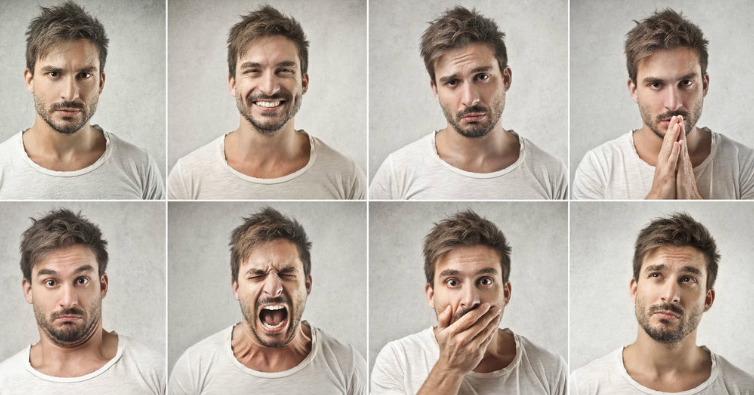

In [56]:
image = cv2.imread('/content/drive/MyDrive/Computer Vision/Images/faces_emotions.png')
cv2_imshow(image)

In [57]:
faces = face_detector.detectMultiScale(image)
faces

array([[625,  49,  91,  91],
       [224,  35,  90,  90],
       [ 23,  41,  92,  92],
       [420,  43,  97,  97],
       [420, 242,  97,  97],
       [ 18, 243,  98,  98],
       [229, 242,  85,  85],
       [627, 241,  91,  91]], dtype=int32)

In [58]:
test_dataset.class_indices.keys()

dict_keys(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

In [59]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


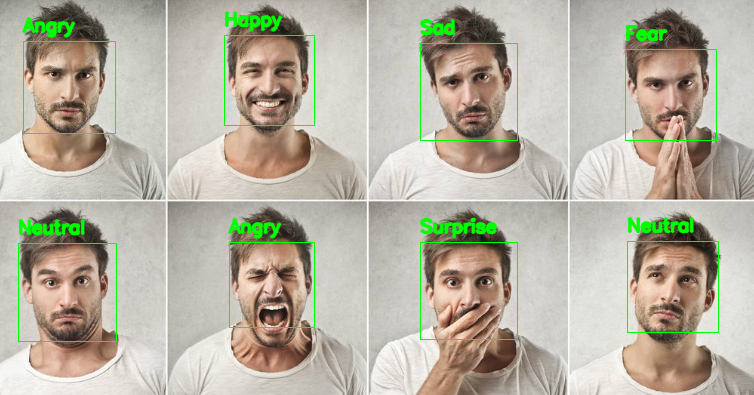

In [60]:
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0,255,0), 1)
    roi = image[y:y+h, x:x+w]
    #cv2_imshow(roi)
    roi = cv2.resize(roi, (48,48))
    #cv2_imshow(roi)
    roi = roi / 255
    roi = np.expand_dims(roi, axis=0)
    #print(roi.shape)
    prediction = network_loaded.predict(roi)
    #print(prediction)
    cv2.putText(image, emotions[np.argmax(prediction)], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)

cv2_imshow(image)

## Classifying emotions in videos

In [61]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Computer Vision/Videos/emotion_test01.mp4')
connected, video = cap.read()
# connected  -> 비디오가 올바르게 로드되었는지 여부를 나타냄.
# video  -> 영상의 형상을 확인

In [62]:
save_path = '/content/drive/MyDrive/Computer Vision/Videos/emotion_test01_result.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # avi영상을 저장하는 데 사용할 코덱을 명시(XVID)
fps = 24  # 낮을수록 영상이 느려짐.
output_video = cv2.VideoWriter(save_path, fourcc, fps, (video.shape[1], video.shape[0]))

In [63]:
# 각 프레임이 하나의 이미지로 간주됨.
while True: # 영상이 끝나면 실행 중단
    connected, frame = cap.read() # 다음 프레임을 읽어옴.

    if not connected:
        break  # 영상이 끝나면 실행 중단

    faces = face_detector.detectMultiScale(frame, scaleFactor=1.2, minNeighbors=5, minSize=(30,30))
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            frame = cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
            roi = frame[y:y+h, x:x+w]
            roi = cv2.resize(roi, (48,48))
            roi = roi / 255
            roi = np.expand_dims(roi, axis=0)
            prediction = network_loaded.predict(roi)

            if prediction is not None:
                result = np.argmax(prediction)
                cv2.putText(frame, emotions[np.argmax(prediction)], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 1, cv2.LINE_AA)

    cv2_imshow(frame)
    output_video.write(frame)

print('End')
output_video.release()
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.